In [1]:
import collections
import json
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Posts to new libs and pairs

In [2]:
with open("data/results/post_to_lib.json") as handle:
    data = json.load(handle)

In [3]:
t0 = time.time()
xs_libs = [d[0] for d in data['distinct_libs_plot']]
ys_libs = [d[1] for d in data['distinct_libs_plot']]
xs_pairs = [d[0] for d in data['distinct_pairs_plot']]
ys_pairs = [d[1] for d in data['distinct_pairs_plot']]
t1 = time.time()
print(f"Segments formed (took {round(t1 - t0, 2)} seconds).")

# Unique libs line fit
libs_a, libs_b  = np.polyfit(range(len(xs_libs)), ys_libs, 1)
pairs_a, pairs_b = np.polyfit(range(len(xs_pairs)), ys_pairs, 1)
t2 = time.time()
print(f"Fits performed (took {round(t2 - t1, 2)} seconds).")

Segments formed (took 1.35 seconds).
Fits performed (took 4.55 seconds).


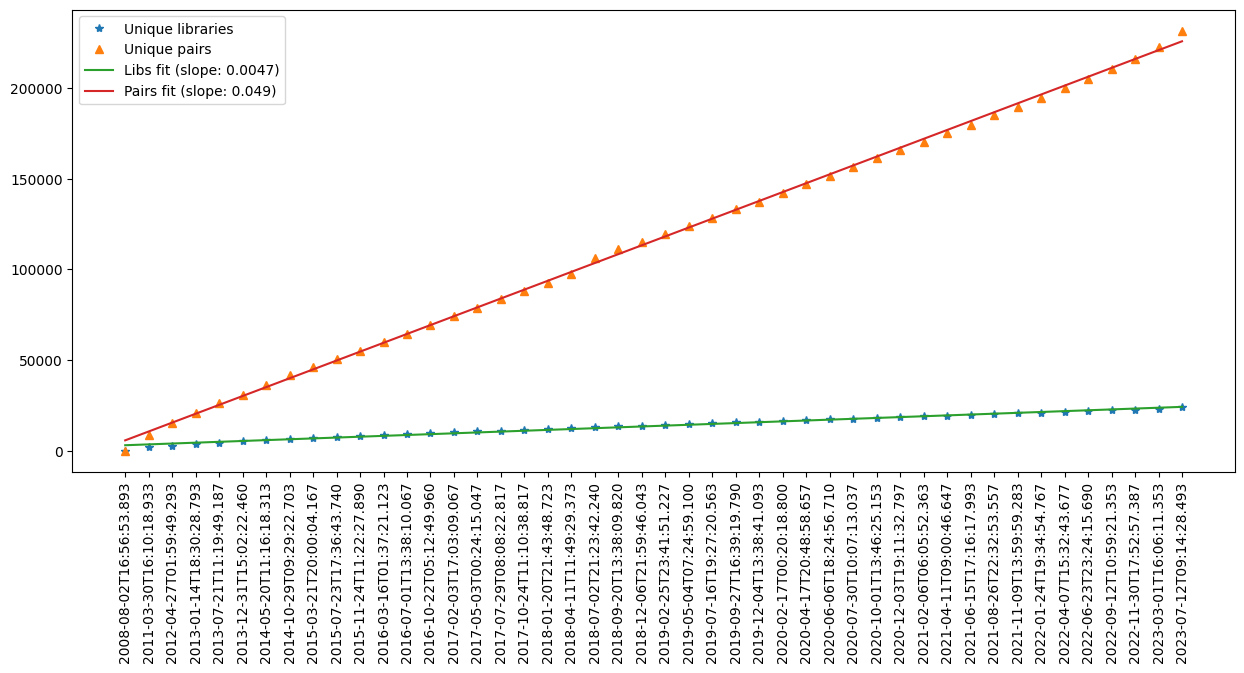

In [7]:
step_size = 100_000

plt.figure(figsize=(15,6))

plt.plot(xs_libs[::step_size], ys_libs[::step_size], "*", label="Unique libraries")
plt.plot(xs_pairs[::step_size], ys_pairs[::step_size], "^", label="Unique pairs")

plt.plot(xs_libs[::step_size], [libs_a * x + libs_b for x in range(len(xs_libs))][::step_size], label=f"Libs fit (slope: {round(libs_a,4)})")
plt.plot(xs_pairs[::step_size], [pairs_a * x + pairs_b for x in range(len(xs_pairs))][::step_size], label=f"Pairs fit (slope: {round(pairs_a, 4)})")

plt.xticks(rotation=90)
plt.legend(loc="upper left")


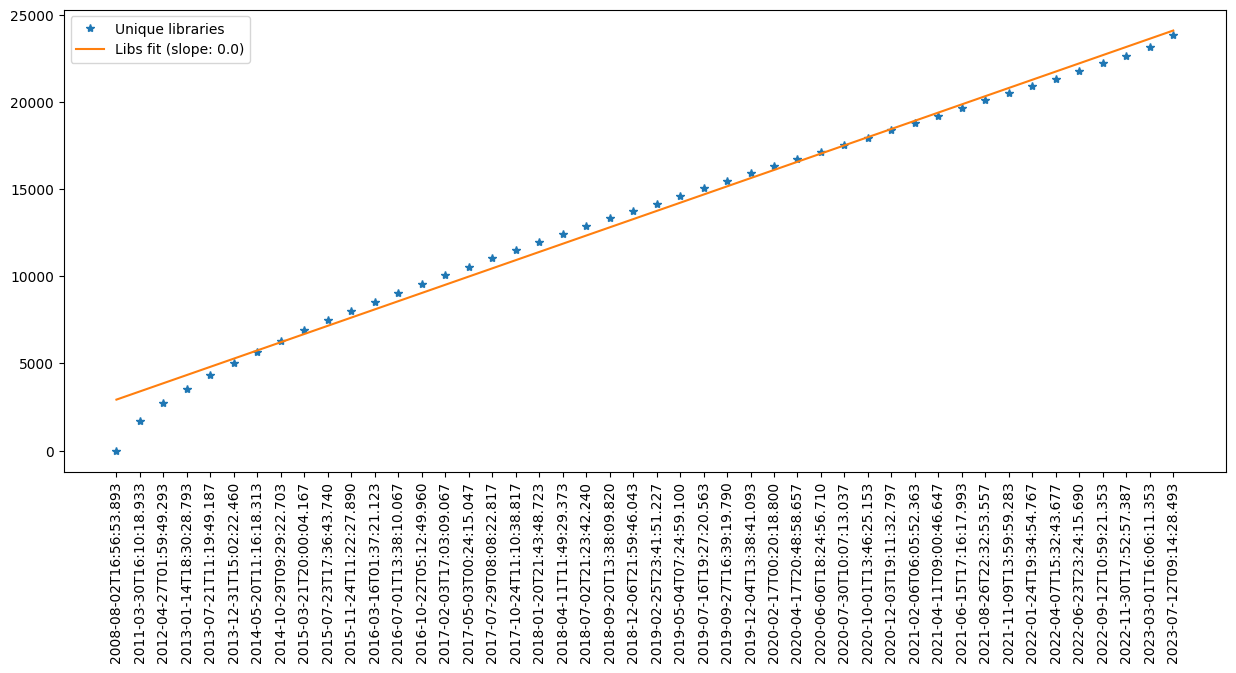

In [5]:
step_size = 100_000

plt.figure(figsize=(15,6))

plt.plot(xs_libs[::step_size], ys_libs[::step_size], "*", label="Unique libraries")
#plt.plot(xs_pairs[::step_size], ys_pairs[::step_size], "^", label="Unique pairs")

plt.plot(xs_libs[::step_size], [libs_a * x + libs_b for x in range(len(xs_libs))][::step_size], label=f"Libs fit (slope: {round(libs_a,2)})")
#plt.plot(xs_pairs[::step_size], [pairs_a * x + pairs_b for x in range(len(xs_pairs))][::step_size], label=f"Pairs fit (slope: {round(pairs_a, 2)})")

plt.xticks(rotation=90)
plt.legend(loc="upper left")


In [6]:
len(data['distinct_libs_plot'])

4583636